# Import
## Add src to import search path

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent
SRC = Path.joinpath(ROOT, "src")

sys.path.append(str(SRC))

## Import necessary libraries

In [2]:
from dataset import Preprocessor
from vae import VAE

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

# Preprocess data

In [3]:
preprocessor = Preprocessor()
x, y = preprocessor.compute_melSpectrogram()
print(x.shape, y.shape)

Processing Dataset: 1000it [00:23, 42.99it/s]


(1000, 128, 1292) (1000,)


# Models

## Enable GPU memory growth

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled")
    except RuntimeError as e:
        print("Memory growth failed:", e)

Memory growth enabled


## Declare variables

In [5]:
EPOCH = 10
BATCH_SIZE = 16
LATENT_DIM = 16
OPTIMIZER_VAE = tf.keras.optimizers.Adam(1e-5)
OPTIMIZER_CVAE = tf.keras.optimizers.Adam(1e-3)

## Vanilla VAE

### Prepare data

In [6]:
x_flat = x.reshape((x.shape[0], -1))
input_dim = x_flat.shape[1]
train_X = tf.data.Dataset.from_tensor_slices(x_flat.astype('float32')).shuffle(x.shape[0]).batch(BATCH_SIZE)

### Train Model

#### PCA + Kmeans training

In [7]:
# PCA training
pca = PCA(n_components=0.95, random_state=42)
x_pca = pca.fit_transform(x_flat)

#Kmeans training
kmeans_pca = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans_pca.fit(x_pca)

KMeans(n_clusters=10, n_init=10, random_state=42)

#### VAE training

In [8]:
vae = VAE(input_dim, LATENT_DIM, "VAE")
vae.fit(train_dataset=train_X, epochs=EPOCH, optimizer=OPTIMIZER_VAE)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch: 1, Training ELBO: -67320.953125
Epoch: 2, Training ELBO: -46048.18359375
Epoch: 3, Training ELBO: -37045.14453125
Epoch: 4, Training ELBO: -41672.71875
Epoch: 5, Training ELBO: -29292.927734375
Epoch: 6, Training ELBO: -3114.69970703125
Epoch: 7, Training ELBO: -2065.74755859375
Epoch: 8, Training ELBO: -2068.1748046875
Epoch: 9, Training ELBO: -2065.324951171875
Epoch: 10, Training ELBO: -2066.661376953125


#### Kmeans training

In [9]:
mean, logvar = vae.encode(x_flat.astype('float32'))
latent_features = mean.numpy() 

kmeans_vae = KMeans(n_clusters=len(np.unique(y)), random_state=42)
kmeans_vae.fit(latent_features)

c:\Users\Sadat\miniconda3\envs\tensor10\lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


KMeans(n_clusters=10, random_state=42)

### Evaluation

#### t-SNE

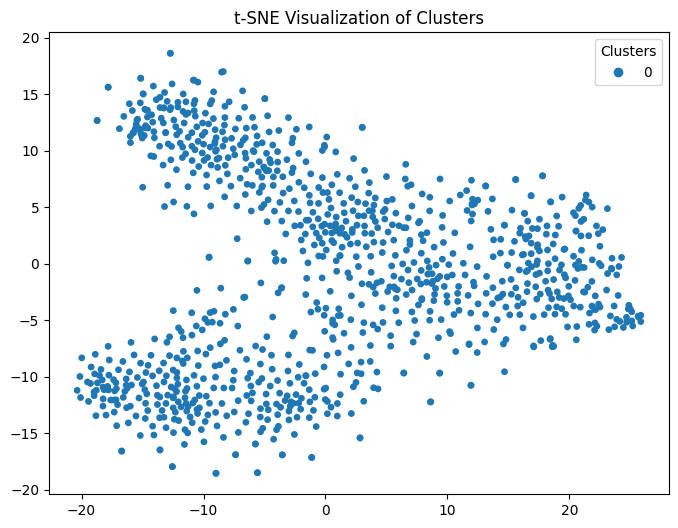

In [10]:
clusters_vae = kmeans_vae.predict(latent_features)

# t-SNE embedding
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
x_tsne = tsne.fit_transform(x_flat)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_tsne[:,0], x_tsne[:,1], c=clusters_vae, cmap='tab10', s=15)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("t-SNE Visualization of Clusters")
plt.show()

#### Silhouette Score and Calinski-Harabasz Index

In [11]:
clusters_vae = kmeans_vae.predict(latent_features)
clusters_pca = kmeans_pca.predict(x_pca)

# Silhouette Score
sil_score_vae = silhouette_score(latent_features, clusters_vae)
sil_score_pca = silhouette_score(x_pca, clusters_pca)
print("Silhouette Scores:", sil_score_vae, sil_score_pca)

# Calinski-Harabasz Index
ch_score_vae = calinski_harabasz_score(latent_features, clusters_vae)
ch_score_pca = calinski_harabasz_score(x_pca, clusters_pca)
print("Calinski-Harabasz Indexes:", ch_score_vae, ch_score_pca)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

## Convolutional VAE

### Prepare data

In [ ]:
x_convo = x.reshape((x.shape[0], x.shape[1], x.shape[2], 1))
input_dim = (x_convo.shape[1], x_convo.shape[2], 1)
train_X = tf.data.Dataset.from_tensor_slices(x_convo.astype('float32')).shuffle(x_convo.shape[0]).batch(BATCH_SIZE)

### Train model

#### VAE training

In [ ]:
cvae = VAE(input_dim, LATENT_DIM, "CVAE")
cvae.fit(train_dataset=train_X, epochs=EPOCH, optimizer=OPTIMIZER_CVAE)

Epoch: 1, Training ELBO: -228034.6875
Epoch: 2, Training ELBO: -1407.48291015625
Epoch: 3, Training ELBO: -214.01171875
Epoch: 4, Training ELBO: -183.43519592285156
Epoch: 5, Training ELBO: -165.73516845703125
Epoch: 6, Training ELBO: -155.9965057373047
Epoch: 7, Training ELBO: -147.89801025390625
Epoch: 8, Training ELBO: -144.6890869140625
Epoch: 9, Training ELBO: -137.22010803222656
Epoch: 10, Training ELBO: -133.61563110351562


#### Kmeans training

In [ ]:
mean, logvar = cvae.encode(x_convo.astype('float32'))
z = cvae.reparameterize(mean, logvar)
latent_features = z.numpy() 

kmeans_vae = KMeans(n_clusters=len(np.unique(y)), random_state=42)
kmeans_vae.fit(latent_features)

ResourceExhaustedError: Exception encountered when calling layer "conv2d_8" "                 f"(type Conv2D).

{{function_node __wrapped__BiasAdd_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1000,64,646,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:BiasAdd]

Call arguments received by layer "conv2d_8" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(1000, 128, 1292, 1), dtype=float32)

### Evaluation

#### t-SNE

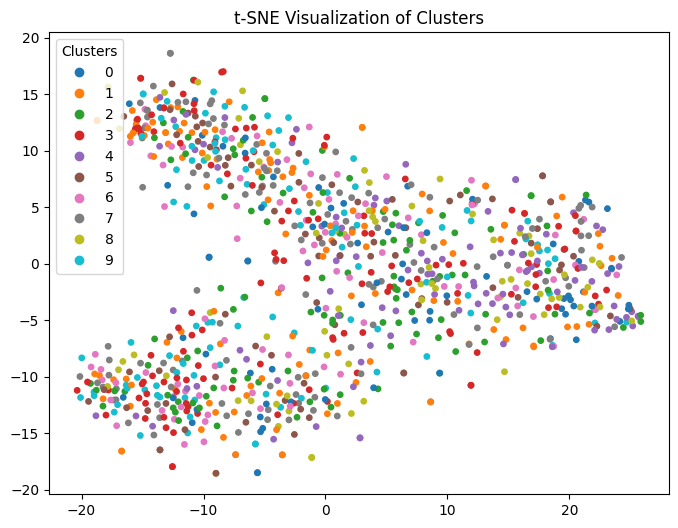

In [ ]:
clusters_vae = kmeans_vae.predict(latent_features)

# t-SNE embedding
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
x_tsne = tsne.fit_transform(x_flat)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_tsne[:,0], x_tsne[:,1], c=clusters_vae, cmap='tab10', s=15)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("t-SNE Visualization of Clusters")
plt.show()

#### Silhouette Score and Calinski-Harabasz Index

In [ ]:
clusters_vae = kmeans_vae.predict(latent_features)
clusters_pca = kmeans_pca.predict(x_pca)

# Silhouette Score
sil_score_vae = silhouette_score(latent_features, clusters_vae)
sil_score_pca = silhouette_score(x_pca, clusters_pca)
print("Silhouette Scores:", sil_score_vae, sil_score_pca)

# Calinski-Harabasz Index
ch_score_vae = calinski_harabasz_score(latent_features, clusters_vae)
ch_score_pca = calinski_harabasz_score(x_pca, clusters_pca)
print("Calinski-Harabasz Indexes:", ch_score_vae, ch_score_pca)


Silhouette Scores: 0.043565795 0.055569377
Calinski-Harabasz Indexes: 32.77602984296993 79.8184127277031


## Beta VAE

### Prepare data

In [12]:
x_convo = x.reshape((x.shape[0], x.shape[1], x.shape[2], 1))
input_dim = (x_convo.shape[1], x_convo.shape[2], 1)
train_X = tf.data.Dataset.from_tensor_slices(x_convo.astype('float32')).shuffle(x_convo.shape[0]).batch(BATCH_SIZE)

### Train model

#### VAE train

In [ ]:
cvae = VAE(input_dim, LATENT_DIM, "CVAE", use_beta=True)
cvae.fit(train_dataset=train_X, epochs=EPOCH, optimizer=OPTIMIZER_CVAE)

Epoch: 1, Training ELBO: -790238.9375
Epoch: 2, Training ELBO: -1459.3006591796875
Epoch: 3, Training ELBO: -245.19873046875
Epoch: 4, Training ELBO: -170.83340454101562
Epoch: 5, Training ELBO: -162.58009338378906
Epoch: 6, Training ELBO: -161.19927978515625
Epoch: 7, Training ELBO: -160.5030517578125
Epoch: 8, Training ELBO: -158.48822021484375
Epoch: 9, Training ELBO: -158.31251525878906
Epoch: 10, Training ELBO: -156.68321228027344


#### Kmeans train

In [14]:
mean, logvar = cvae.encode(x_convo.astype('float32'))
z = cvae.reparameterize(mean, logvar)
latent_features = z.numpy() 

kmeans_vae = KMeans(n_clusters=len(np.unique(y)), random_state=42)
kmeans_vae.fit(latent_features)

ResourceExhaustedError: Exception encountered when calling layer "conv2d" "                 f"(type Conv2D).

{{function_node __wrapped__BiasAdd_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1000,64,646,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:BiasAdd]

Call arguments received by layer "conv2d" "                 f"(type Conv2D):
  • inputs=tf.Tensor(shape=(1000, 128, 1292, 1), dtype=float32)

### Evaluation

#### t-SNE

In [ ]:
clusters_vae = kmeans_vae.predict(latent_features)

# t-SNE embedding
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
x_tsne = tsne.fit_transform(x_flat)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_tsne[:,0], x_tsne[:,1], c=clusters_vae, cmap='tab10', s=15)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("t-SNE Visualization of Clusters")
plt.show()

#### Silhouette Score and Calinski-Harabasz Index

In [ ]:
clusters_vae = kmeans_vae.predict(latent_features)
clusters_pca = kmeans_pca.predict(x_pca)

# Silhouette Score
sil_score_vae = silhouette_score(latent_features, clusters_vae)
sil_score_pca = silhouette_score(x_pca, clusters_pca)
print("Silhouette Scores:", sil_score_vae, sil_score_pca)

# Calinski-Harabasz Index
ch_score_vae = calinski_harabasz_score(latent_features, clusters_vae)
ch_score_pca = calinski_harabasz_score(x_pca, clusters_pca)
print("Calinski-Harabasz Indexes:", ch_score_vae, ch_score_pca)